# **Enhancing 6D Object Pose Estimation**

**TA:** Stephany Ortuno Chanelo (stephany.ortuno@polito.it)

**TASK OVERVIEW**
This project aims to explore and implement advanced techniques for 6D pose estimation using RGB-D images. The goal is to build an end-to-end pipeline for estimating the 6D pose of objects by initially replicating a model that uses just RGB images. The pipeline will then be enhanced by incorporating depth information to improve accuracy in the pose predictions. You will adapt and implement the methodology, starting from pose prediction and then extend the model with your own innovative improvements.


In [1]:
# Go to directory
!mkdir -p datasets/linemod/
%cd datasets/linemod/

/content/datasets/linemod


In [2]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Unzip Dataset

from google.colab import drive
import shutil
import os

# 2. Define Paths
# Assuming you saved the file in the main folder of your Drive ('My Drive')
drive_path = '/content/drive/MyDrive/Linemod_preprocessed.zip'
colab_path = '/content/Linemod_preprocessed.zip'

# 3. Copy file from Drive to Colab Local Runtime
# This is usually very fast (seconds)
if os.path.exists(drive_path):
    print(f"Found file at {drive_path}. Copying to local runtime...")
    shutil.copy(drive_path, colab_path)
    print("Copy complete!")

    # 4. Unzip
    print("Unzipping dataset...")
    !unzip -q {colab_path}  # -q means "quiet" (hides the long list of files)
    print("Unzip complete! Dataset is ready.")
else:
    print(f"Error: Could not find '{drive_path}'.")
    print("Make sure you renamed the file correctly in your Google Drive.")

Found file at /content/drive/MyDrive/Linemod_preprocessed.zip. Copying to local runtime...
Copy complete!
Unzipping dataset...
Unzip complete! Dataset is ready.


In [4]:
! pip install ultralytics pcl trimesh pandas

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 740.4/740.4 kB 55.8 MB/s eta 0:00:00
  Created wheel for pcl: filename=pcl-0.0.0.post1-py3-none-any.whl size=1690 sha256=ecbe647c8eac7efc0a4de44659163019578ddde9249455dfc31db07f1e4d313f
  Stored in directory: /root/.cache/pip/wheels/70/63/a5/01bf8671f269ba8a6ae44ef331b9a99201f8cf287b1a031c5f
Successfully built pcl


In [5]:
import os
import yaml
import torch
import glob
import random
import math
import cv2

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision.transforms as transforms

from ultralytics import YOLO
from pathlib import Path

from collections import defaultdict
from scipy.spatial.transform import Rotation as R

from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

import trimesh
import pandas as pd
from tqdm.notebook import tqdm
from sklearn import metrics
from torchvision import models

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
# YOLO Data Pre-Processing

# --- CONFIGURATION ---
DATASET_ROOT = "/content/datasets/linemod/Linemod_preprocessed/data"

# Standard LineMod ID to Name mapping
LINEMOD_ID_MAP = {
    '01': 'ape', '02': 'benchvise', '04': 'cam', '05': 'can',
    '06': 'cat', '08': 'driller', '09': 'duck', '10': 'eggbox',
    '11': 'glue', '12': 'holepuncher', '13': 'iron', '14': 'lamp', '15': 'phone'
}

def process_dataset_fast():
    if not os.path.exists(DATASET_ROOT):
        print(f"Error: Path '{DATASET_ROOT}' not found.")
        return

    print(f"Scanning for classes in: {DATASET_ROOT}")

    # 1. Identify Valid Folders
    available_folders = [f for f in sorted(os.listdir(DATASET_ROOT))
                         if f in LINEMOD_ID_MAP and os.path.isdir(os.path.join(DATASET_ROOT, f))]

    if not available_folders:
        print("No valid class folders found!")
        return

    # Map Folder Name ('01') -> YOLO ID (0, 1, 2...)
    folder_to_yolo_id = {folder: i for i, folder in enumerate(available_folders)}

    # 2. Process gt.yml -> YOLO Labels
    for folder_name in available_folders:
        yolo_id = folder_to_yolo_id[folder_name]
        real_name = LINEMOD_ID_MAP[folder_name]

        # Helper to convert folder string '02' to integer 2 for comparison with gt.yml
        target_obj_id = int(folder_name)

        folder_path = os.path.join(DATASET_ROOT, folder_name)
        gt_path = os.path.join(folder_path, "gt.yml")
        rgb_dir = os.path.join(folder_path, "rgb")

        print(f"Processing '{real_name}' (ID: {yolo_id}) using gt.yml...")

        if not os.path.exists(gt_path):
            print(f"  Warning: gt.yml not found in {folder_name}. Skipping.")
            continue

        # Get Image Dimensions (Open one image to check size)
        sample_imgs = glob.glob(os.path.join(rgb_dir, "*.png")) + glob.glob(os.path.join(rgb_dir, "*.jpg"))
        if not sample_imgs:
            print(f"  Warning: No images found in {rgb_dir}")
            continue

        img = cv2.imread(sample_imgs[0])
        img_h, img_w = img.shape[:2]

        # Load Metadata
        with open(gt_path, 'r') as f:
            gt_data = yaml.safe_load(f)

        count = 0
        for img_id_int, anns in gt_data.items():
            file_id = f"{img_id_int:04d}"

            # Search through ALL annotations for this image to find the one matching our class
            target_ann = None
            for annotation in anns:
                if annotation['obj_id'] == target_obj_id:
                    target_ann = annotation
                    break

            # If the specific object (e.g., Benchvise) isn't in this image, skip the image
            if target_ann is None:
                continue

            x, y, w, h = target_ann['obj_bb']

            # Normalize for YOLO: [x_center, y_center, width, height]
            x_center = (x + w / 2) / img_w
            y_center = (y + h / 2) / img_h
            w_norm = w / img_w
            h_norm = h / img_h

            # Write to .txt file in the RGB folder
            label_path = os.path.join(rgb_dir, f"{file_id}.txt")

            with open(label_path, 'w') as f_out:
                f_out.write(f"{yolo_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

            count += 1

        print(f"  -> Generated {count} labels in 'rgb' folder.")

    # 3. Create linemod.yaml automatically
    yaml_content = {
        'path': os.path.abspath(DATASET_ROOT),
        'train': 'train.txt',
        'val': 'val.txt',
        'test': 'test.txt',
        'names': {i: LINEMOD_ID_MAP[folder] for i, folder in enumerate(available_folders)}
    }

    with open('linemod.yaml', 'w') as f:
        yaml.dump(yaml_content, f)

    print("\nSuccess! 'linemod.yaml' created.")
    print("Class mapping:", yaml_content['names'])

process_dataset_fast()

Scanning for classes in: /content/datasets/linemod/Linemod_preprocessed/data
Processing 'ape' (ID: 0) using gt.yml...
  -> Generated 1236 labels in 'rgb' folder.
Processing 'benchvise' (ID: 1) using gt.yml...
  -> Generated 1214 labels in 'rgb' folder.
Processing 'cam' (ID: 2) using gt.yml...
  -> Generated 1201 labels in 'rgb' folder.
Processing 'can' (ID: 3) using gt.yml...
  -> Generated 1196 labels in 'rgb' folder.
Processing 'cat' (ID: 4) using gt.yml...
  -> Generated 1179 labels in 'rgb' folder.
Processing 'driller' (ID: 5) using gt.yml...
  -> Generated 1188 labels in 'rgb' folder.
Processing 'duck' (ID: 6) using gt.yml...
  -> Generated 1254 labels in 'rgb' folder.
Processing 'eggbox' (ID: 7) using gt.yml...
  -> Generated 1253 labels in 'rgb' folder.
Processing 'glue' (ID: 8) using gt.yml...
  -> Generated 1220 labels in 'rgb' folder.
Processing 'holepuncher' (ID: 9) using gt.yml...
  -> Generated 1237 labels in 'rgb' folder.
Processing 'iron' (ID: 10) using gt.yml...
  -> Ge

In [ ]:
# Data Splitting (train-val-test.txt)

# --- CONFIGURATION ---
DATASET_ROOT = "./datasets/linemod/Linemod_preprocessed/data"
OUTPUT_DIR = "."

def create_scientific_split():
    all_images = []

    # 1. Collect ALL images
    valid_folders = [f for f in sorted(os.listdir(DATASET_ROOT))
                     if os.path.isdir(os.path.join(DATASET_ROOT, f)) and f.isdigit()]

    for folder in valid_folders:
        rgb_path = os.path.join(DATASET_ROOT, folder, "rgb")
        if os.path.exists(rgb_path):
            for filename in os.listdir(rgb_path):
                if filename.endswith(".png") or filename.endswith(".jpg"):
                    full_path = os.path.abspath(os.path.join(rgb_path, filename))
                    all_images.append(full_path)

    # 2. Shuffle and Split (60% / 20% / 20%)
    total_images = len(all_images)
    random.seed(42)
    random.shuffle(all_images)

    # Calculate indices
    train_end = int(total_images * 0.6)
    val_end = int(total_images * 0.8) # 60% + 20% = 80%

    train_imgs = all_images[:train_end]
    val_imgs   = all_images[train_end:val_end] # The slice from 60% to 80%
    test_imgs  = all_images[val_end:]          # The slice from 80% to 100%

    # 3. Write to THREE files
    with open(os.path.join(OUTPUT_DIR, "train.txt"), 'w') as f:
        f.write('\n'.join(train_imgs))

    with open(os.path.join(OUTPUT_DIR, "val.txt"), 'w') as f:
        f.write('\n'.join(val_imgs))

    with open(os.path.join(OUTPUT_DIR, "test.txt"), 'w') as f:
        f.write('\n'.join(test_imgs))

    print(f"Split Complete:")
    print(f"  Train: {len(train_imgs)} (60%)")
    print(f"  Val:   {len(val_imgs)} (20%)")
    print(f"  Test:  {len(test_imgs)} (20%)")

    # 4. Update linemod.yaml to use all three
    try:
        if os.path.exists('linemod.yaml'):
            with open('linemod.yaml', 'r') as f:
                config = yaml.safe_load(f)
        else:
            config = {'names': {}}

        config['train'] = os.path.abspath("train.txt")
        config['val'] = os.path.abspath("val.txt")   # YOLO uses this during training
        config['test'] = os.path.abspath("test.txt") # Purely for your final eval

        with open('linemod.yaml', 'w') as f:
            yaml.dump(config, f)
        print("Updated 'linemod.yaml' correctly.")

    except Exception as e:
        print(f"Warning: Could not update linemod.yaml: {e}")

create_scientific_split()

In [ ]:
# YOLO Training

DRIVE_SAVE_PATH = '/content/drive/MyDrive/6DAML/yolo/yolo_60-20-20_epc50'

model_yolo = YOLO('yolov8n.pt')

results = model_yolo.train(
    data='linemod.yaml',
    epochs=50,
    imgsz=640,
    project=DRIVE_SAVE_PATH,
    name='train_yolo_60_20_20_epc50',     # Name of the sub-folder
    verbose=True
)

In [12]:
# YOLO Prediction

# --- CONFIGURATION ---
DRIVE_SAVE_PATH = '/content/drive/MyDrive/6DAML/yolo/yolo_60-20-20_epc50'
TRAIN_RUN_NAME = 'train_yolo_60_20_20_epc50'

# Construct the path to your trained 'best.pt' weights
model_weights = os.path.join(DRIVE_SAVE_PATH, TRAIN_RUN_NAME, 'weights', 'best.pt')
output_base_dir = '/content/yolo/predictions_test_set_epc50'
# output_base_dir = os.path.join(DRIVE_SAVE_PATH, 'predictions_test_set_epc50')

if not os.path.exists(model_weights):
    print(f"Error: Model weights not found at {model_weights}")
else:
    print(f"Loading model from: {model_weights}")
    model = YOLO(model_weights)

    # 1. Read the image paths from test.txt
    with open('/content/datasets/linemod/Linemod_preprocessed/data/test.txt', 'r') as f:
        image_paths = [line.strip() for line in f.readlines() if line.strip()]

    print(f"Processing {len(image_paths)} images individually to preserve folder structure...")

    # 2. Iterate through each image path
    for img_path in image_paths:

        p = Path(img_path)
        filename = p.stem
        obj_id = p.parent.parent.name

        save_dir = os.path.join(output_base_dir, obj_id)
        os.makedirs(save_dir, exist_ok=True)

        # 3. Run Prediction on single image
        results = model.predict(
            source=img_path,
            save=False,
            save_txt=False,
            conf=0.5,
            verbose=False
        )

        result = results[0]   # Get the single result object

        # 4. Manually Save TXT
        txt_path = os.path.join(save_dir, f"{filename}.txt")

        with open(txt_path, 'w') as f_out:
            for box in result.boxes:
                x, y, w, h = box.xywhn[0].tolist()
                conf = box.conf[0].item()
                cls = int(box.cls[0].item())

                # Write line: class x y w h conf
                line = f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f} {conf:.6f}\n"
                f_out.write(line)

        # 5. Manually Save Image (Visualisation)
        img_save_path = os.path.join(save_dir, f"{filename}.jpg")
        plotted_img = result.plot() # Returns the image as a BGR numpy array
        cv2.imwrite(img_save_path, plotted_img)

    print("-" * 40)
    print(f"Predictions Complete!")
    print(f"Results separated by object folders in: {output_base_dir}")

Loading model from: /content/drive/MyDrive/6DAML/yolo/yolo_60-20-20_epc50/train_yolo_60_20_20_epc50/weights/best.pt
Processing 3160 images individually to preserve folder structure...
----------------------------------------
Predictions Complete!
Results separated by object folders in: /content/yolo/predictions_test_set_epc50


In [13]:
# PINHOLE MATH #1: Loading Models Info & Camera Intrincstics

# --- CONFIGURATION ---
# 1. Path to your models_info.yml (contains physical diameters)
MODELS_INFO_PATH = '/content/datasets/linemod/Linemod_preprocessed/models/models_info.yml'

# 2. Path to your YOLO results
YOLO_RESULTS_PATH = '/content/yolo/predictions_test_set_epc50'
# --- CONSTANTS ---
# Camera Intrinsics (From info.yml)
# K matrix: [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
FX = 572.4114
FY = 573.57043
CX = 325.2611
CY = 242.04899

# Image Resolution
IMG_WIDTH = 640
IMG_HEIGHT = 480

# --- LOAD MODELS INFO ---
# Real Diameter (D_real) for each object class
if os.path.exists(MODELS_INFO_PATH):
    print(f"Loading object info from: {MODELS_INFO_PATH}")
    with open(MODELS_INFO_PATH, 'r') as f:
        models_info = yaml.safe_load(f)

    print(f"Object 1 Diameter: {models_info[1]['diameter']} mm")
    print(models_info)
else:
    print(f"ERROR: models_info.yml not found at {MODELS_INFO_PATH}")

print("Setup Complete.")

Loading object info from: /content/datasets/linemod/Linemod_preprocessed/models/models_info.yml
Object 1 Diameter: 102.09865663 mm
{1: {'diameter': 102.09865663, 'min_x': -37.9343, 'min_y': -38.7996, 'min_z': -45.8845, 'size_x': 75.8686, 'size_y': 77.5992, 'size_z': 91.769}, 2: {'diameter': 247.50624233, 'min_x': -107.835, 'min_y': -60.9279, 'min_z': -109.705, 'size_x': 215.67, 'size_y': 121.8557, 'size_z': 219.41}, 3: {'diameter': 167.35486092, 'min_x': -83.2162, 'min_y': -82.6591, 'min_z': -37.2364, 'size_x': 166.4324, 'size_y': 165.3182, 'size_z': 74.4728}, 4: {'diameter': 172.49224865, 'min_x': -68.3297, 'min_y': -71.5151, 'min_z': -50.2485, 'size_x': 136.6594, 'size_y': 143.0302, 'size_z': 100.497}, 5: {'diameter': 201.40358597, 'min_x': -50.3958, 'min_y': -90.8979, 'min_z': -96.867, 'size_x': 100.7916, 'size_y': 181.7958, 'size_z': 193.734}, 6: {'diameter': 154.54551808, 'min_x': -33.5054, 'min_y': -63.8165, 'min_z': -58.7283, 'size_x': 67.0107, 'size_y': 127.633, 'size_z': 117.4

In [14]:
# PINHOLE MATH #2: Translation Estimation Function

def estimate_translation_pinhole(box_norm, real_diameter_mm):
    """
    Calculates the 3D Translation Vector (Tpred) using Pinhole Camera Geometry.

    Args:
        box_norm (list or np.array): [x_center, y_center, width, height]
                                     Normalized coordinates (0.0 to 1.0).
        real_diameter_mm (float): The physical diameter of the object in mm.

    Returns:
        np.array: [tx, ty, tz] in millimeters.
    """

    # 1. Unpack Normalized YOLO Coordinates
    x_n, y_n, w_n, h_n = box_norm

    # 2. Convert to Pixel Coordinates
    u_c = x_n * IMG_WIDTH   # Center X in pixels
    v_c = y_n * IMG_HEIGHT  # Center Y in pixels
    w_px = w_n * IMG_WIDTH  # Width in pixels
    h_px = h_n * IMG_HEIGHT # Height in pixels

    # 3. Calculate Diagonal in Pixels (d_pixel)
    d_pixel = math.sqrt(w_px**2 + h_px**2)

    if d_pixel == 0:
        return np.array([0.0, 0.0, 0.0])

    # 4. Estimate Depth (tz)
    # The ratio of Real Size to Depth is proportional to Pixel Size to Focal Length.
    # Formula: tz = (f * D_real) / d_pixel
    # f = (fx + fy) / 2
    f_avg = (FX + FY) / 2.0
    tz = (f_avg * real_diameter_mm) / d_pixel

    # 5. Estimate Position (tx, ty)
    # Back-project the center pixel (u,v) into 3D space using the calculated depth.
    # Formula: tx = (u - cx) * tz / fx
    tx = (u_c - CX) * tz / FX
    ty = (v_c - CY) * tz / FY

    return np.array([tx, ty, tz])

print("Translation estimation function defined.")

Translation estimation function defined.


In [15]:
# PINHOLE MATH #3: Translation Estimation Main

# 1. Input Path (Where YOLO txt files are)
print(f"Reading YOLO results from: {YOLO_RESULTS_PATH}")

# 2. Output Path (Where to save Translation results)
TRANSLATION_OUTPUT_DIR = '/content/baseline_translation/predictions'

# Create the main output directory if it doesn't exist
os.makedirs(TRANSLATION_OUTPUT_DIR, exist_ok=True)
print(f"Saving Translation results to: {TRANSLATION_OUTPUT_DIR}")

# --- HELPER TO GET DIAMETER ---
def get_diameter(class_id, models_info):
    info = models_info.get(class_id) or models_info.get(str(class_id))
    if info:
        return info['diameter']
    else:
        return None

# --- MAIN LOOP ---
# Get all subfolders from the YOLO results
subfolders = sorted([f.path for f in os.scandir(YOLO_RESULTS_PATH) if f.is_dir()])

total_files_processed = 0

print("-" * 80)
print(f"{'Folder':<8} | {'File':<10} | {'MappedID':<8} | {'Tx (mm)':>9} | {'Ty (mm)':>9} | {'Tz (mm)':>9}")
print("-" * 80)

for folder in subfolders:
    folder_name = os.path.basename(folder) # 01-15 excluding 03 & 07

    # 1. Create corresponding subfolder in the Output Directory
    current_output_folder = os.path.join(TRANSLATION_OUTPUT_DIR, folder_name)
    os.makedirs(current_output_folder, exist_ok=True)

    # 2. Find YOLO .txt files
    txt_files = sorted(glob.glob(os.path.join(folder, "*.txt")))
    txt_files = [f for f in txt_files if "_translation.txt" not in f]

    if not txt_files:
        continue

    for i, txt_path in enumerate(txt_files):

        # A. Read YOLO Result
        with open(txt_path, 'r') as f:
            content = f.read().strip()

        if not content:
            continue

        # B. Parse the SINGLE row: "class x y w h conf"
        data = list(map(float, content.split()))
        yolo_cls_id = int(data[0])
        box_norm = data[1:5] # [x, y, w, h]

        # C. Identify the Real Object ID
        # Rely on the FOLDER NAME.
        try:
            real_object_id = int(folder_name)
        except ValueError:
            print(f"Error: Folder name '{folder_name}' is not a valid integer ID. Skipping.")
            continue

        # D. Get Real Diameter using the REAL ID
        real_diameter = get_diameter(real_object_id, models_info)

        if real_diameter is None:
            print(f"Warning: No diameter found for Object ID {real_object_id} (Folder: {folder_name})")
            continue

        # E. CALCULATE TRANSLATION
        t_pred = estimate_translation_pinhole(box_norm, real_diameter)

        # F. Save the Result to the new folder
        base_name = os.path.basename(txt_path)
        save_path = os.path.join(current_output_folder, base_name)

        with open(save_path, 'w') as f_out:
            # Saving as: tx ty tz
            f_out.write(f"{t_pred[0]:.6f} {t_pred[1]:.6f} {t_pred[2]:.6f}")

        total_files_processed += 1

        # G. Visual Check (First 3 files of each folder)
        if i < 3:
            print(f"{folder_name:<8} | {base_name.replace('.txt',''):<10} | {real_object_id:<8} | {t_pred[0]:9.2f} | {t_pred[1]:9.2f} | {t_pred[2]:9.2f}")

print("-" * 80)
print(f"Done! Processed {total_files_processed} files.")
print(f"All results saved in: {TRANSLATION_OUTPUT_DIR}")

Reading YOLO results from: /content/yolo/predictions_test_set_epc50
Saving Translation results to: /content/baseline_translation/predictions
--------------------------------------------------------------------------------
Folder   | File       | MappedID |   Tx (mm) |   Ty (mm) |   Tz (mm)
--------------------------------------------------------------------------------
01       | 0003       | 1        |    -88.10 |    -11.07 |    855.14
01       | 0012       | 1        |   -116.51 |    100.49 |    922.18
01       | 0013       | 1        |   -114.28 |    122.28 |    936.95
02       | 0001       | 2        |    -29.09 |     -6.02 |   1075.94
02       | 0010       | 2        |   -149.32 |     80.27 |    979.79
02       | 0012       | 2        |   -105.45 |     49.06 |   1041.67
04       | 0000       | 4        |     89.92 |     43.80 |    885.06
04       | 0004       | 4        |    134.26 |      8.03 |    797.07
04       | 0018       | 4        |     54.66 |    -32.76 |    659.38
05     

In [18]:
# PINHOLE MATH #4: Evaluation

# Predicted translations
PRED_RESULTS_PATH = '/content/baseline_translation/predictions'

# Dataset Ground Truths
DATASET_ROOT = '/content/datasets/linemod/Linemod_preprocessed/data'

# Output Report File
REPORT_PATH = os.path.join(PRED_RESULTS_PATH, 'translation_error_report.txt')

# --- HELPER FUNCTION ---
def calc_euclidean_distance(t1, t2):
    return math.sqrt((t1[0]-t2[0])**2 + (t1[1]-t2[1])**2 + (t1[2]-t2[2])**2)

# --- MAIN EXECUTION ---
print(f"Calculating Translation Error...")
print(f"Reading Predictions from: {PRED_RESULTS_PATH}")
print(f"Reading Ground Truth from: {DATASET_ROOT}")

# Storage for metrics
object_metrics = {}
global_errors = []

# Get result subfolders
subfolders = sorted([f.path for f in os.scandir(PRED_RESULTS_PATH) if f.is_dir()])

# Open the report file to write results
with open(REPORT_PATH, 'w') as report:
    header = f"{'Object':<8} | {'Count':<6} | {'Avg Error (mm)':<15} | {'Min Error':<10} | {'Max Error':<10}\n"
    report.write(header)
    report.write("-" * 60 + "\n")
    print("-" * 60)
    print(header.strip())
    print("-" * 60)

    for folder in subfolders:
        folder_name = os.path.basename(folder)

        # Load Ground Truth for this object
        gt_path = os.path.join(DATASET_ROOT, folder_name, 'gt.yml')
        if not os.path.exists(gt_path):
            print(f"Warning: GT file not found for {folder_name} at {gt_path}")
            continue

        with open(gt_path, 'r') as f:
            gt_data = yaml.safe_load(f)

        # Find all prediction files
        pred_files = sorted(glob.glob(os.path.join(folder, "*.txt")))

        current_obj_errors = []

        # Identify the Target ID strictly from the folder name ("02" -> 2)
        try:
            target_obj_id = int(folder_name)
        except ValueError:
            print(f"Skipping folder {folder_name}: Cannot parse integer ID.")
            continue

        for pred_file in pred_files:
            # Parse Prediction
            with open(pred_file, 'r') as f:
                content = f.read().strip()
            if not content: continue

            # Pinhole Prediction: [tx, ty, tz]
            t_pred = list(map(float, content.split()))

            # Identify Frame ID from filename ("0055.txt" -> 55)
            filename = os.path.basename(pred_file)
            file_id_str = os.path.splitext(filename)[0]

            try:
                img_id = int(file_id_str)
            except ValueError:
                continue

            # Retrieve Ground Truth
            if img_id not in gt_data:
                continue

            # gt_data[frame_id] -> list of all objects in that image.
            gt_instances = gt_data[img_id]
            t_gt = None

            for instance in gt_instances:
                # Only accept if the ID matches our folder
                if instance['obj_id'] == target_obj_id:
                    t_gt = instance['cam_t_m2c']
                    break

            # Object wasn't labeled in this GT frame
            if t_gt is None:
                continue

            # Calculate Error
            error = calc_euclidean_distance(t_pred, t_gt)
            current_obj_errors.append(error)
            global_errors.append(error)

        # Aggregate Results for this Object
        if current_obj_errors:
            avg_err = np.mean(current_obj_errors)
            min_err = np.min(current_obj_errors)
            max_err = np.max(current_obj_errors)
            count = len(current_obj_errors)

            object_metrics[folder_name] = avg_err

            # Log to console and file
            line = f"{folder_name:<8} | {count:<6} | {avg_err:<15.4f} | {min_err:<10.2f} | {max_err:<10.2f}"
            print(line)
            report.write(line + "\n")
        else:
            print(f"{folder_name:<8} | 0      | N/A")

    # Final Global Average
    print("-" * 60)
    if global_errors:
        total_avg = np.mean(global_errors)
        summary = f"TOTAL AVERAGE TRANSLATION ERROR: {total_avg:.4f} mm"
        print(summary)
        report.write("-" * 60 + "\n")
        report.write(summary + "\n")
        print(f"Report saved to: {REPORT_PATH}")
    else:
        print("No metrics calculated. Check paths.")

Calculating Translation Error...
Reading Predictions from: /content/baseline_translation/predictions
Reading Ground Truth from: /content/datasets/linemod/Linemod_preprocessed/data
------------------------------------------------------------
Object   | Count  | Avg Error (mm)  | Min Error  | Max Error
------------------------------------------------------------
01       | 230    | 106.3721        | 5.60       | 226.11    
02       | 246    | 93.1128         | 6.99       | 219.65    
04       | 212    | 140.1138        | 52.17      | 253.22    
05       | 250    | 136.7095        | 1.75       | 293.81    
06       | 239    | 78.4696         | 6.41       | 215.77    
08       | 235    | 92.1296         | 4.55       | 215.19    
09       | 264    | 153.4963        | 73.02      | 258.82    
10       | 254    | 119.1218        | 9.62       | 261.19    
11       | 260    | 138.4977        | 5.22       | 913.87    
12       | 258    | 115.2706        | 3.30       | 243.37    
13       | 239   

In [19]:
# ROTATION ESTIMATION #1: Convert YOLO results to Absolute Pixel Coordinates and save as YAML

import os
import yaml
import glob
from pathlib import Path
from tqdm import tqdm

# --- CONFIGURATION ---
INPUT_BASE_DIR = '/content/yolo/predictions_test_set_epc50'
OUTPUT_FILENAME = 'yolo.yml'

# Image Dimensions for LineMod (Standard)
IMG_WIDTH = 640
IMG_HEIGHT = 480

# --- 1. ID MAPPING SETUP ---
LINEMOD_ID_MAP = {
    '01': 'ape', '02': 'benchvise', '04': 'cam', '05': 'can',
    '06': 'cat', '08': 'driller', '09': 'duck', '10': 'eggbox',
    '11': 'glue', '12': 'holepuncher', '13': 'iron', '14': 'lamp', '15': 'phone'
}

# Reverse Map: Class Index 0 -> LineMod ID 1, Class Index 2 -> LineMod ID 4...
sorted_keys = sorted(LINEMOD_ID_MAP.keys())
YOLO_TO_LINEMOD = {i: int(k) for i, k in enumerate(sorted_keys)}

# --- 2. YAML FORMATTER CLASS ---
# This class forces PyYAML to write specific lists in [a, b, c, d] format (Flow Style)
class FlowList(list):
    pass

def flow_list_representer(dumper, data):
    return dumper.represent_sequence(u'tag:yaml.org,2002:seq', data, flow_style=True)

yaml.add_representer(FlowList, flow_list_representer)

# --- 3. MAIN PROCESSING ---
def parse_yolo_to_yaml():
    if not os.path.exists(INPUT_BASE_DIR):
        print(f"Error: Directory {INPUT_BASE_DIR} does not exist.")
        return

    obj_folders = sorted([
        f for f in os.listdir(INPUT_BASE_DIR)
        if os.path.isdir(os.path.join(INPUT_BASE_DIR, f))
    ])

    print(f"Converting YOLO results to Absolute Pixel Coordinates (640x480)...")

    for folder_name in tqdm(obj_folders, desc="Processing Folders"):
        folder_path = os.path.join(INPUT_BASE_DIR, folder_name)
        folder_data = {}

        txt_files = glob.glob(os.path.join(folder_path, "*.txt"))

        for txt_file in txt_files:
            try:
                frame_id = int(Path(txt_file).stem) # 0000 -> 0
            except ValueError:
                continue

            with open(txt_file, 'r') as f:
                lines = f.readlines()

            detections = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 6:
                    continue

                # 1. Parse Normalized Data
                cls_idx = int(parts[0])
                x_norm = float(parts[1])
                y_norm = float(parts[2])
                w_norm = float(parts[3])
                h_norm = float(parts[4])
                conf = float(parts[5])

                # 2. Convert to Absolute Pixel Coordinates
                x_center = x_norm * IMG_WIDTH
                y_center = y_norm * IMG_HEIGHT
                w_abs = w_norm * IMG_WIDTH
                h_abs = h_norm * IMG_HEIGHT
                x_top_left = x_center - (w_abs / 2)
                y_top_left = y_center - (h_abs / 2)


                # 3. Handle ID Mapping
                if cls_idx in YOLO_TO_LINEMOD:
                    real_obj_id = YOLO_TO_LINEMOD[cls_idx]
                else:
                    continue

                # 4. Create Entry
                # obj_bb gets [x, y, w, h] - confidence is separate
                bbox_data = FlowList([
                    round(x_top_left, 4),
                    round(y_top_left, 4),
                    round(w_abs, 4),
                    round(h_abs, 4)
                ])

                detections.append({
                    'obj_id': real_obj_id,
                    'obj_bb': bbox_data,
                    'confidence': round(conf, 6)
                })

            if detections:
                folder_data[frame_id] = detections

        # Save to YAML
        output_path = os.path.join(folder_path, OUTPUT_FILENAME)
        with open(output_path, 'w') as f_out:
            yaml.dump(folder_data, f_out, sort_keys=True)

    print(f"Conversion Complete. Results in {OUTPUT_FILENAME}")

if __name__ == "__main__":
    parse_yolo_to_yaml()

Converting YOLO results to Absolute Pixel Coordinates (640x480)...


Processing Folders: 100%|██████████| 13/13 [00:00<00:00, 17.71it/s]

Conversion Complete. Results in yolo.yml


In [20]:
# ROTATION ESTIMATION #2: Dataset Loader

# Standard ImageNet normalization
TRANSFORMS = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class LineModRotationDataset(Dataset):
    def __init__(self, root_dir, split_file, transform=TRANSFORMS, use_yolo_boxes=False):
        """
        Args:
            root_dir (str): Path to LineMod root (containing the 'data' folder).
            split_file (str): Path to the .txt file (train.txt/test.txt).
            transform (callable, optional): PyTorch transforms.
            use_yolo_boxes (bool): If True, loads bbox from 'yolo.yml' instead of 'gt.yml'.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.use_yolo_boxes = use_yolo_boxes

        if not os.path.exists(split_file):
            raise FileNotFoundError(f"Split file not found: {split_file}")

        # 1. PARSE SPLIT FILE
        images_per_folder = defaultdict(list)
        print(f"Parsing split file: {split_file} (YOLO Mode: {use_yolo_boxes})...")

        with open(split_file, 'r') as f:
            for line in f:
                path_str = line.strip()
                if not path_str: continue

                parts = path_str.split('/') # Ensure forward slashes usually, or use os.sep
                if len(parts) < 2: parts = path_str.split('\\') # Handle Windows paths

                # Extract Obj ID (folder name) and Image ID (filename)
                obj_id_str = next((p for p in parts if p.isdigit() and len(p) == 2), None)

                if obj_id_str:
                    file_name = parts[-1]
                    try:
                        img_id = int(os.path.splitext(file_name)[0])
                        images_per_folder[obj_id_str].append(img_id)
                    except ValueError:
                        continue

        # 2. ITERATE FOLDERS
        sorted_folders = sorted(images_per_folder.keys())

        for obj_id_str in sorted_folders:
            base_path = os.path.join(root_dir, obj_id_str)
            gt_path = os.path.join(base_path, 'gt.yml')
            yolo_path = os.path.join('/content/yolo/predictions_test_set_epc50', obj_id_str, 'yolo.yml')

            target_ids = images_per_folder[obj_id_str]

            if not os.path.exists(gt_path):
                print(f"[{obj_id_str}] Missing gt.yml. Skipping.")
                continue

            # Load GT (Always needed for Rotation Labels)
            with open(gt_path, 'r') as f:
                full_gt = yaml.safe_load(f)

            # Load YOLO (Only if requested)
            full_yolo = {}
            if self.use_yolo_boxes:
                if os.path.exists(yolo_path):
                    with open(yolo_path, 'r') as f:
                        full_yolo = yaml.safe_load(f)
                else:
                    print(f"[{obj_id_str}] Warning: yolo.yml missing. Skipping folder.")
                    continue

            obj_id_int = int(obj_id_str)
            valid_count = 0

            for img_id_int in target_ids:
                # 1. VALIDATION: Must exist in GT (for Label)
                if img_id_int not in full_gt:
                    continue

                # 2. RETRIEVE GT LABEL (Rotation)
                gt_anns = full_gt[img_id_int]
                valid_gt_ann = None

                # Benchvise Filter / ID Check
                for ann in gt_anns:
                    if ann['obj_id'] == obj_id_int:
                        valid_gt_ann = ann
                        break

                if valid_gt_ann is None:
                    continue

                # 3. RETRIEVE BOUNDING BOX
                final_bbox = None

                if self.use_yolo_boxes:
                    # Case: Test Set (Use Predicted Box)
                    if img_id_int in full_yolo and full_yolo[img_id_int]:
                        # Assuming the first detection is the correct one (highest conf)
                        # Structure: List of dicts
                        yolo_ann = full_yolo[img_id_int][0]
                        final_bbox = yolo_ann['obj_bb'] # [x, y, w, h] from yolo.yml
                    else:
                        # YOLO missed the object. Skip sample.
                        print(f"[{obj_id_str}] Image {img_id_int:04d} - YOLO box missing. Skipping sample.")
                        continue
                else:
                    # Case: Train/Val Set (Use GT Box)
                    final_bbox = valid_gt_ann['obj_bb']

                # 4. STORE SAMPLE
                img_name = f"{img_id_int:04d}.png"
                img_path = os.path.join(base_path, 'rgb', img_name)


                rot_matrix = np.array(valid_gt_ann['cam_R_m2c']).reshape(3, 3)
                quat = R.from_matrix(rot_matrix).as_quat() # [x, y, z, w]

                self.samples.append({
                    'path': img_path,
                    'obj_bb': final_bbox,             # [x, y, w, h] (GT or YOLO)
                    'cam_R_m2c': quat,                # from GT
                    'cam_t_m2c': valid_gt_ann['cam_t_m2c'],
                    'obj_id': obj_id_int,
                    'img_id': img_id_int
                })
                valid_count += 1

            # print(f"[{obj_id_str}] Loaded {valid_count} samples.")

        print(f"=== DATASET LOADED: {len(self.samples)} samples (YOLO Boxes: {self.use_yolo_boxes}) ===")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load Image
        image = cv2.imread(sample['path'])
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 1. Crop
        x, y, w, h = map(int, sample['obj_bb'])

        # 2. Safety clamp to image dimensions
        h_img, w_img, _ = image.shape
        x = max(0, x)
        y = max(0, y)
        w = min(w, w_img - x)
        h = min(h, h_img - y)

        if w <= 0 or h <= 0:
             # Handle degenerate boxes (YOLO predicted 0 width/height or outside image)
             crop = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
             crop = image[y:y+h, x:x+w]

        # 3. Process Rotation
        # rot_matrix = np.array(sample['cam_R_m2c']).reshape(3, 3)
        # quat = R.from_matrix(rot_matrix).as_quat() # [x, y, z, w]

        if self.transform:
            crop = self.transform(crop)

        return {
            'image': crop,
            'rotation': torch.tensor(sample['cam_R_m2c'], dtype=torch.float32),
            'obj_id': torch.tensor(sample['obj_id'], dtype=torch.long),
            'img_id': torch.tensor(sample['img_id'], dtype=torch.long),
            'cam_t_m2c': torch.tensor(sample['cam_t_m2c'], dtype=torch.float32)
        }

In [21]:
# ROTATION ESTIMATION #3: ResNet-50 Model (Un-Frozen)

import torch.nn as nn
from torchvision import models

class ResNetRotation(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetRotation, self).__init__()
        # Load Pretrained ResNet
        self.backbone = models.resnet50(weights='DEFAULT')

        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features

        # Freeze all layers except the final fully connected layer
        # for param in self.backbone.parameters():
        #     param.requires_grad = False

        # Output: 4 values for Quaternion (q_x, q_y, q_z, q_w)
        # self.backbone.fc = nn.Linear(in_features, 4)

        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        x = self.backbone(x)
        # Normalize quaternion
        x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x

In [22]:
# ROTATION ESTIMATION #4: Parameter Counts
# Instantiate your model
model = ResNetRotation(pretrained=True)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

# EXPECTED OUTPUT:
# Total Parameters: ~23,500,000
# Trainable Parameters: ~8,196 for frozen backbone, ~24M for unfrozen backbone

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


Total Parameters: 24,559,172
Trainable Parameters: 24,559,172


In [25]:
# ROTATION ESTIMATION #5: Data Loader Calls

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
LR = 0.0001

train_dataset = LineModRotationDataset(root_dir="/content/datasets/linemod/Linemod_preprocessed/data", split_file="/content/datasets/linemod/Linemod_preprocessed/data/train.txt", use_yolo_boxes=False)
val_dataset   = LineModRotationDataset(root_dir="/content/datasets/linemod/Linemod_preprocessed/data", split_file="/content/datasets/linemod/Linemod_preprocessed/data/val.txt", use_yolo_boxes=False)
test_dataset  = LineModRotationDataset(root_dir="/content/datasets/linemod/Linemod_preprocessed/data", split_file="/content/datasets/linemod/Linemod_preprocessed/data/test.txt", use_yolo_boxes=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print(f"Data Loaded Successfully:")
print(f"  Train: {len(train_dataset)} images")
print(f"  Val:   {len(val_dataset)} images")
print(f"  Test:  {len(test_dataset)} images")


Parsing split file: /content/datasets/linemod/Linemod_preprocessed/data/train.txt (YOLO Mode: False)...
=== DATASET LOADED: 9480 samples (YOLO Boxes: False) ===
Parsing split file: /content/datasets/linemod/Linemod_preprocessed/data/val.txt (YOLO Mode: False)...
=== DATASET LOADED: 3160 samples (YOLO Boxes: False) ===
Parsing split file: /content/datasets/linemod/Linemod_preprocessed/data/test.txt (YOLO Mode: True)...
=== DATASET LOADED: 3160 samples (YOLO Boxes: True) ===
Data Loaded Successfully:
  Train: 9480 images
  Val:   3160 images
  Test:  3160 images


In [26]:
# ROTATION ESTIMATION #6: Quaternion Loss Function

class QuaternionRotationLoss(nn.Module):
    """
    Computes the loss between predicted and ground truth quaternions.
    Calculated as: 1 - |dot_product(q_pred, q_gt)|

    This handles the 'double cover' problem where q and -q represent
    the same rotation.
    """
    def __init__(self):
        super(QuaternionRotationLoss, self).__init__()

    def forward(self, pred_q, gt_q):
        # 1. Normalize the predicted quaternions to unit length
        # (This is crucial: Cosine similarity assumes unit vectors)
        pred_q = torch.nn.functional.normalize(pred_q, p=2, dim=1)

        # 2. Compute the dot product along the batch dimension
        # Shape: (Batch_Size, 1)
        dot_product = torch.sum(pred_q * gt_q, dim=1)

        # 3. Calculate Loss
        # We take the absolute value of the dot product to handle q == -q
        loss = 1.0 - torch.abs(dot_product)

        # Return mean over the batch
        return loss.mean()

In [27]:
# ROTATION ESTIMATION #7: Training Loop

save_dir = "/content/baseline_rotation"
results_dir = "/content/baseline_rotation"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

history_save_path = os.path.join(results_dir, "best_model_history.txt")

model = ResNetRotation().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
criterion = QuaternionRotationLoss()

train_loss_history = []
val_loss_history = []
EPOCHS = 50

print("Starting ResNet Training (Rotation Branch Only)...")

# Initialize history file with headers
with open(history_save_path, "w") as f:
    f.write("Epoch,Train_Loss,Val_Loss\n")

best_val_loss = float('inf')

# --- TRAINING LOOP ---
for epoch in range(EPOCHS):

    # --- TRAIN STEP ---
    model.train()
    running_train_loss = 0.0

    # Wrap train_loader with tqdm for progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)

    for batch in train_loop:
        images = batch['image'].to(DEVICE)
        gt_rot = batch['rotation'].to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, gt_rot)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Update progress bar description with current loss
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # --- VALIDATION STEP ---
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(DEVICE)
            gt_rot = batch['rotation'].to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, gt_rot)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    # Step the scheduler
    scheduler.step(avg_val_loss)

    print(f"Current LR: {scheduler.get_last_lr()}")

    # --- SAVE HISTORY TO FILE ---
    # Append ('a') so we save progress even if the script crashes later
    with open(history_save_path, "a") as f:
        f.write(f"{epoch+1},{avg_train_loss:.6f},{avg_val_loss:.6f}\n")

    # --- CHECKPOINTING ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

        save_path = os.path.join(save_dir, "best_rotation_baseline_res50_no_freeze.pth")
        torch.save(model.state_dict(), save_path)

        print(f"Epoch {epoch+1} Results | Train: {avg_train_loss:.5f} | Val: {avg_val_loss:.5f} | *Saved Best*")
    else:
        print(f"Epoch {epoch+1} Results | Train: {avg_train_loss:.5f} | Val: {avg_val_loss:.5f}")

print("Training Complete.")

Starting ResNet Training (Rotation Branch Only)...


Epoch 1/50: 100%|██████████| 593/593 [03:43<00:00,  2.65it/s, loss=0.0962]


Current LR: [0.0001]
Epoch 1 Results | Train: 0.16338 | Val: 0.09114 | *Saved Best*


Epoch 2/50: 100%|██████████| 593/593 [03:43<00:00,  2.65it/s, loss=0.183]


Current LR: [0.0001]
Epoch 2 Results | Train: 0.07103 | Val: 0.07375 | *Saved Best*


Epoch 3/50: 100%|██████████| 593/593 [03:44<00:00,  2.65it/s, loss=0.0363]


Current LR: [0.0001]
Epoch 3 Results | Train: 0.05797 | Val: 0.04975 | *Saved Best*


Epoch 4/50: 100%|██████████| 593/593 [03:42<00:00,  2.66it/s, loss=0.0595]


Current LR: [0.0001]
Epoch 4 Results | Train: 0.07409 | Val: 0.07229


Epoch 5/50: 100%|██████████| 593/593 [03:44<00:00,  2.64it/s, loss=0.0865]


Current LR: [0.0001]
Epoch 5 Results | Train: 0.08095 | Val: 0.06431


Epoch 6/50: 100%|██████████| 593/593 [03:44<00:00,  2.64it/s, loss=0.0516]


Current LR: [0.0001]
Epoch 6 Results | Train: 0.05842 | Val: 0.05641


Epoch 7/50: 100%|██████████| 593/593 [03:43<00:00,  2.65it/s, loss=0.0563]


Current LR: [1e-05]
Epoch 7 Results | Train: 0.07228 | Val: 0.09199


Epoch 8/50: 100%|██████████| 593/593 [03:43<00:00,  2.66it/s, loss=0.0263]


Current LR: [1e-05]
Epoch 8 Results | Train: 0.07367 | Val: 0.04979


Epoch 9/50: 100%|██████████| 593/593 [03:42<00:00,  2.67it/s, loss=0.0608]


Current LR: [1e-05]
Epoch 9 Results | Train: 0.05645 | Val: 0.04403 | *Saved Best*


Epoch 10/50: 100%|██████████| 593/593 [03:39<00:00,  2.70it/s, loss=0.0421]


Current LR: [1e-05]
Epoch 10 Results | Train: 0.04698 | Val: 0.03778 | *Saved Best*


Epoch 11/50: 100%|██████████| 593/593 [03:39<00:00,  2.70it/s, loss=0.0336]


Current LR: [1e-05]
Epoch 11 Results | Train: 0.04165 | Val: 0.03345 | *Saved Best*


Epoch 12/50: 100%|██████████| 593/593 [03:40<00:00,  2.68it/s, loss=0.0154]


Current LR: [1e-05]
Epoch 12 Results | Train: 0.03914 | Val: 0.03067 | *Saved Best*


Epoch 13/50: 100%|██████████| 593/593 [03:41<00:00,  2.67it/s, loss=0.0377]


Current LR: [1e-05]
Epoch 13 Results | Train: 0.03609 | Val: 0.02880 | *Saved Best*


Epoch 14/50: 100%|██████████| 593/593 [03:40<00:00,  2.70it/s, loss=0.0214]


Current LR: [1e-05]
Epoch 14 Results | Train: 0.03479 | Val: 0.02711 | *Saved Best*


Epoch 15/50: 100%|██████████| 593/593 [03:43<00:00,  2.65it/s, loss=0.0158]


Current LR: [1e-05]
Epoch 15 Results | Train: 0.03320 | Val: 0.02782


Epoch 16/50: 100%|██████████| 593/593 [03:41<00:00,  2.68it/s, loss=0.0254]


Current LR: [1e-05]
Epoch 16 Results | Train: 0.03065 | Val: 0.02594 | *Saved Best*


Epoch 17/50: 100%|██████████| 593/593 [03:45<00:00,  2.64it/s, loss=0.083]


Current LR: [1e-05]
Epoch 17 Results | Train: 0.02875 | Val: 0.02318 | *Saved Best*


Epoch 18/50: 100%|██████████| 593/593 [03:41<00:00,  2.67it/s, loss=0.0335]


Current LR: [1e-05]
Epoch 18 Results | Train: 0.02639 | Val: 0.02162 | *Saved Best*


Epoch 19/50: 100%|██████████| 593/593 [03:41<00:00,  2.68it/s, loss=0.0285]


Current LR: [1e-05]
Epoch 19 Results | Train: 0.02819 | Val: 0.02488


Epoch 20/50: 100%|██████████| 593/593 [03:40<00:00,  2.68it/s, loss=0.0183]


Current LR: [1e-05]
Epoch 20 Results | Train: 0.02778 | Val: 0.02565


Epoch 21/50: 100%|██████████| 593/593 [03:40<00:00,  2.69it/s, loss=0.0221]


Current LR: [1e-05]
Epoch 21 Results | Train: 0.03097 | Val: 0.02443


Epoch 22/50: 100%|██████████| 593/593 [03:40<00:00,  2.69it/s, loss=0.0843]


Current LR: [1.0000000000000002e-06]
Epoch 22 Results | Train: 0.02697 | Val: 0.02260


Epoch 23/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0149]


Current LR: [1.0000000000000002e-06]
Epoch 23 Results | Train: 0.02673 | Val: 0.02122 | *Saved Best*


Epoch 24/50: 100%|██████████| 593/593 [03:39<00:00,  2.70it/s, loss=0.0131]


Current LR: [1.0000000000000002e-06]
Epoch 24 Results | Train: 0.02582 | Val: 0.02060 | *Saved Best*


Epoch 25/50: 100%|██████████| 593/593 [03:39<00:00,  2.71it/s, loss=0.015]


Current LR: [1.0000000000000002e-06]
Epoch 25 Results | Train: 0.02501 | Val: 0.02095


Epoch 26/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0283]


Current LR: [1.0000000000000002e-06]
Epoch 26 Results | Train: 0.02460 | Val: 0.02111


Epoch 27/50: 100%|██████████| 593/593 [03:37<00:00,  2.72it/s, loss=0.0135]


Current LR: [1.0000000000000002e-06]
Epoch 27 Results | Train: 0.02343 | Val: 0.02017 | *Saved Best*


Epoch 28/50: 100%|██████████| 593/593 [03:38<00:00,  2.72it/s, loss=0.022]


Current LR: [1.0000000000000002e-06]
Epoch 28 Results | Train: 0.02465 | Val: 0.02332


Epoch 29/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0227]


Current LR: [1.0000000000000002e-06]
Epoch 29 Results | Train: 0.02444 | Val: 0.02125


Epoch 30/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0185]


Current LR: [1.0000000000000002e-06]
Epoch 30 Results | Train: 0.02354 | Val: 0.01924 | *Saved Best*


Epoch 31/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0795]


Current LR: [1.0000000000000002e-06]
Epoch 31 Results | Train: 0.02299 | Val: 0.01993


Epoch 32/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0402]


Current LR: [1.0000000000000002e-06]
Epoch 32 Results | Train: 0.02259 | Val: 0.02059


Epoch 33/50: 100%|██████████| 593/593 [03:39<00:00,  2.70it/s, loss=0.0159]


Current LR: [1.0000000000000002e-06]
Epoch 33 Results | Train: 0.02268 | Val: 0.01985


Epoch 34/50: 100%|██████████| 593/593 [03:40<00:00,  2.69it/s, loss=0.014]


Current LR: [1.0000000000000002e-06]
Epoch 34 Results | Train: 0.02265 | Val: 0.01877 | *Saved Best*


Epoch 35/50: 100%|██████████| 593/593 [03:38<00:00,  2.72it/s, loss=0.0221]


Current LR: [1.0000000000000002e-06]
Epoch 35 Results | Train: 0.02314 | Val: 0.01880


Epoch 36/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.115]


Current LR: [1.0000000000000002e-06]
Epoch 36 Results | Train: 0.02226 | Val: 0.01940


Epoch 37/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0333]


Current LR: [1.0000000000000002e-06]
Epoch 37 Results | Train: 0.02321 | Val: 0.01990


Epoch 38/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0252]


Current LR: [1.0000000000000002e-07]
Epoch 38 Results | Train: 0.02205 | Val: 0.02123


Epoch 39/50: 100%|██████████| 593/593 [03:37<00:00,  2.73it/s, loss=0.0169]


Current LR: [1.0000000000000002e-07]
Epoch 39 Results | Train: 0.02177 | Val: 0.01984


Epoch 40/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.00948]


Current LR: [1.0000000000000002e-07]
Epoch 40 Results | Train: 0.02274 | Val: 0.02063


Epoch 41/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0123]


Current LR: [1.0000000000000002e-07]
Epoch 41 Results | Train: 0.02235 | Val: 0.02063


Epoch 42/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.03]


Current LR: [1.0000000000000002e-07]
Epoch 42 Results | Train: 0.02179 | Val: 0.01818 | *Saved Best*


Epoch 43/50: 100%|██████████| 593/593 [03:39<00:00,  2.71it/s, loss=0.0136]


Current LR: [1.0000000000000002e-07]
Epoch 43 Results | Train: 0.02196 | Val: 0.02014


Epoch 44/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0389]


Current LR: [1.0000000000000002e-07]
Epoch 44 Results | Train: 0.02156 | Val: 0.01958


Epoch 45/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0135]


Current LR: [1.0000000000000002e-07]
Epoch 45 Results | Train: 0.02218 | Val: 0.01949


Epoch 46/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0119]


Current LR: [1.0000000000000004e-08]
Epoch 46 Results | Train: 0.02191 | Val: 0.02052


Epoch 47/50: 100%|██████████| 593/593 [03:39<00:00,  2.71it/s, loss=0.0372]


Current LR: [1.0000000000000004e-08]
Epoch 47 Results | Train: 0.02200 | Val: 0.02001


Epoch 48/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.128]


Current LR: [1.0000000000000004e-08]
Epoch 48 Results | Train: 0.02309 | Val: 0.01948


Epoch 49/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0272]


Current LR: [1.0000000000000004e-08]
Epoch 49 Results | Train: 0.02173 | Val: 0.01934


Epoch 50/50: 100%|██████████| 593/593 [03:38<00:00,  2.71it/s, loss=0.0476]


Current LR: [1.0000000000000004e-08]
Epoch 50 Results | Train: 0.02184 | Val: 0.01912
Training Complete.


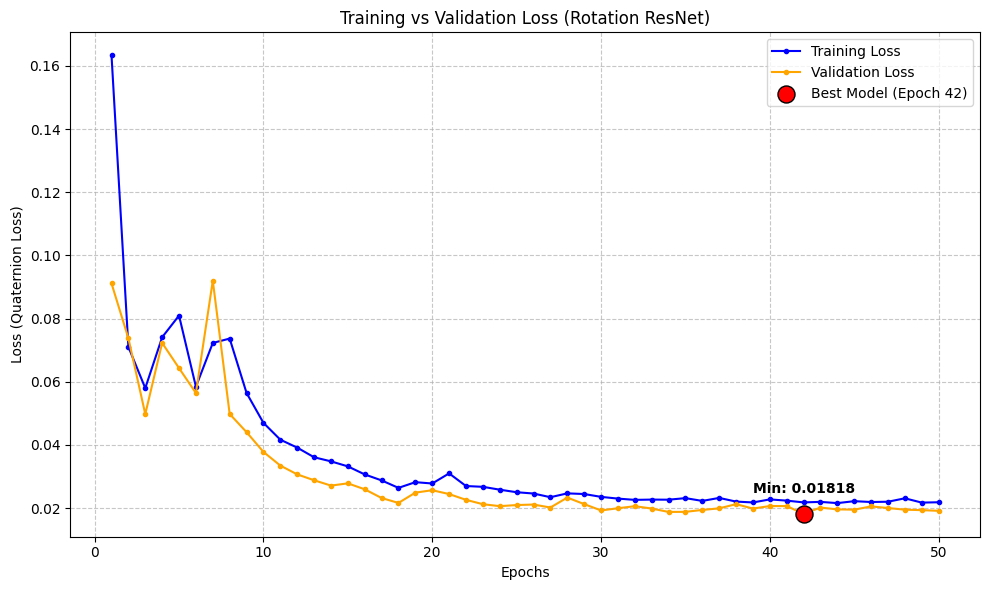

In [28]:
# ROTATION ESTIMATION #8: Plotting Train & Val Loss

plt.figure(figsize=(10, 6))
epochs_range = range(1, len(train_loss_history) + 1)

# Plot Lines
plt.plot(epochs_range, train_loss_history, label='Training Loss', marker='.', color='blue')
plt.plot(epochs_range, val_loss_history, label='Validation Loss', marker='.', color='orange')

# Find and Highlight the Best Epoch
if val_loss_history:
    best_val = min(val_loss_history)
    best_epoch = val_loss_history.index(best_val) + 1

    plt.scatter(best_epoch, best_val, color='red', s=150, zorder=5,
                label=f'Best Model (Epoch {best_epoch})', edgecolors='black')

    plt.annotate(f"Min: {best_val:.5f}", (best_epoch, best_val),
                 xytext=(0, 15), textcoords='offset points', ha='center', fontweight='bold')

plt.title('Training vs Validation Loss (Rotation ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Quaternion Loss)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [30]:
# ROTATION ESTIMATION #9: Quaternion Loss Calculation

model = ResNetRotation().to(DEVICE)
criterion = QuaternionRotationLoss()

print("Loading best model weights for final testing...")
model.load_state_dict(torch.load("/content/baseline_rotation/best_rotation_baseline_res50_no_freeze.pth"))
model.eval()

running_test_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(DEVICE)
        gt_rot = batch['rotation'].to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, gt_rot)
        running_test_loss += loss.item()

final_test_loss = running_test_loss / len(test_loader)
print("-" * 30)
print(f"FINAL TEST LOSS (Quaternion Loss): {final_test_loss:.5f}")
print("-" * 30)

Loading best model weights for final testing...
------------------------------
FINAL TEST LOSS (Quaternion Loss): 0.01968
------------------------------


In [31]:
# ROTATION ESTIMATION #10: (Global) Average Rotation Error Calculation

def compute_angular_error(pred_q, gt_q):
    """
    Returns a tensor of angular errors (in degrees) for the batch.
    Shape: [Batch_Size]
    """
    pred_q = torch.nn.functional.normalize(pred_q, p=2, dim=1)
    gt_q = torch.nn.functional.normalize(gt_q, p=2, dim=1)

    # Dot product
    dot_product = torch.sum(pred_q * gt_q, dim=1)
    # Clamp for numerical stability
    dot_product = torch.clamp(dot_product, -1.0, 1.0)

    # Handle Antipodal (Double Cover): q and -q are the same
    theta = 2 * torch.acos(torch.abs(dot_product))
    return torch.rad2deg(theta)

model = ResNetRotation().to(DEVICE)
model.load_state_dict(torch.load("/content/baseline_rotation/best_rotation_baseline_res50_no_freeze.pth"))

model.eval()
per_object_errors = defaultdict(list)

with torch.no_grad():
    for batch in test_loader:
        # Move data to device
        images = batch['image'].to(DEVICE)
        gt_rot = batch['rotation'].to(DEVICE)
        obj_ids = batch['obj_id'].cpu().numpy()

        # Predict
        outputs = model(images)

        # Calculate errors for the whole batch
        batch_errors = compute_angular_error(outputs, gt_rot)

        # Group errors by object ID
        for i, obj_id in enumerate(obj_ids):
            error_val = batch_errors[i].item()
            per_object_errors[obj_id].append(error_val)

# Print Results
print("\n" + "="*40)
print(f"{'OBJECT':<15} | {'AVG ROTATION ERR (Deg)':<20}")
print("-" * 40)

total_errors = []

# Sort by ID for clean output
for obj_id in sorted(per_object_errors.keys()):
    obj_name = LINEMOD_ID_MAP.get(obj_id, f"Obj {obj_id}")
    errors = per_object_errors[obj_id]

    avg_error = np.mean(errors)
    total_errors.extend(errors)

    print(f"{obj_name:<15} | {avg_error:.4f}")

print("-" * 40)
print(f"{'OVERALL MEAN':<15} | {np.mean(total_errors):.4f}")
print("="*40)



OBJECT          | AVG ROTATION ERR (Deg)
----------------------------------------
Obj 1           | 19.7240
Obj 2           | 17.9467
Obj 4           | 17.5482
Obj 5           | 15.7323
Obj 6           | 17.0455
Obj 8           | 17.4449
Obj 9           | 22.6454
Obj 10          | 17.8318
Obj 11          | 19.8701
Obj 12          | 19.2629
Obj 13          | 17.4553
Obj 14          | 17.5004
Obj 15          | 20.6813
----------------------------------------
OVERALL MEAN    | 18.5503


In [45]:
# BASELINE EVALUATION

# --- 1. CONFIGURATION (BASELINE) ---
BASE_SAVE_DIR = "/content/drive/MyDrive/6DAML/baseline"
RESULT_SAVE_PATH = os.path.join(BASE_SAVE_DIR, "evaluation_results_baseline_pinhole_resnet.txt")

# Data Paths
DATA_ROOT = "/content/datasets/linemod/Linemod_preprocessed/data"
MESH_PATH_TEMPLATE = "/content/datasets/linemod/Linemod_preprocessed/models/obj_{:02d}.ply"
TEST_SPLIT_FILE = os.path.join(DATA_ROOT, "test.txt")
MODELS_INFO_PATH = "/content/datasets/linemod/Linemod_preprocessed/models/models_info.yml"

# 1. YOLO Results
YOLO_PREDS_PATH = "/content/yolo/predictions_test_set_epc50"

# 2. Pinhole Translation Results
PATH_PINHOLE_TXT = "/content/baseline_translation/predictions"

# 3. ResNet Rotation Model
PATH_RESNET_MODEL = "/content/baseline_rotation/best_rotation_baseline_res50_no_freeze.pth"

# Constants
SYMMETRIC_IDS = [10, 11] # Eggbox, Glue
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- MODEL DEFINITION ---
class ResNetRotation(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetRotation, self).__init__()
        # Load Pretrained ResNet
        self.backbone = models.resnet50(weights='DEFAULT')

        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features

        # Output: 4 values for Quaternion (q_x, q_y, q_z, q_w)
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        x = self.backbone(x)
        # Normalize quaternion
        x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x

In [46]:
# --- 2. EVALUATOR CLASS ---
class SixDPoseEvaluator:
    def __init__(self, mesh_template, symmetric_ids, diameters_path):
        self.mesh_template = mesh_template
        self.symmetric_ids = symmetric_ids
        self.meshes = {}
        self.diameters = self._load_diameters(diameters_path)

    def _load_diameters(self, path):
        if not os.path.exists(path):
            return {1: 0.102, 2: 0.247, 3: 0.127, 4: 0.117, 5: 0.150,
                    6: 0.127, 8: 0.152, 9: 0.151, 10: 0.151, 11: 0.165,
                    12: 0.169, 13: 0.207, 14: 0.239, 15: 0.163}
        with open(path, 'r') as f:
            data = yaml.safe_load(f)
        return {int(k): v['diameter'] / 1000.0 for k, v in data.items()}

    def load_mesh(self, obj_id):
        if obj_id not in self.meshes:
            path = self.mesh_template.format(obj_id)
            if os.path.exists(path):
                mesh = trimesh.load(path)
                self.meshes[obj_id] = mesh.vertices * 0.001 # MM to Meters
            else:
                self.meshes[obj_id] = np.random.rand(500, 3) * 0.1
        return self.meshes[obj_id]

    def compute_add(self, gt_R, gt_t, pred_R, pred_t, vertices):
        gt_pts = (np.dot(vertices, gt_R.T) + gt_t)
        pred_pts = (np.dot(vertices, pred_R.T) + pred_t)
        return np.mean(np.linalg.norm(gt_pts - pred_pts, axis=1))

    def compute_add_s(self, gt_R, gt_t, pred_R, pred_t, vertices):
        gt_pts = (np.dot(vertices, gt_R.T) + gt_t)
        pred_pts = (np.dot(vertices, pred_R.T) + pred_t)
        from scipy.spatial import cKDTree
        tree = cKDTree(pred_pts)
        dist, _ = tree.query(gt_pts)
        return np.mean(dist)

    def evaluate_sample(self, obj_id, pred_R, pred_t, gt_R, gt_t):
        verts = self.load_mesh(obj_id)
        diameter = self.diameters.get(obj_id, 0.1)

        # 1. ADD
        add_val = self.compute_add(gt_R, gt_t, pred_R, pred_t, verts)

        # 2. ADD-S
        if obj_id in self.symmetric_ids:
            adds_val = self.compute_add_s(gt_R, gt_t, pred_R, pred_t, verts)
        else:
            adds_val = None

        # 3. ADD-R (Rotation Only)
        zero_t = np.zeros(3)
        if obj_id in self.symmetric_ids:
            addr_val = self.compute_add_s(gt_R, zero_t, pred_R, zero_t, verts)
        else:
            addr_val = self.compute_add(gt_R, zero_t, pred_R, zero_t, verts)

        # 4. Pose Errors
        trans_error = np.linalg.norm(gt_t - pred_t)

        R_diff = np.dot(pred_R, gt_R.T)
        trace = np.trace(R_diff)
        trace = np.clip((trace - 1) / 2, -1.0, 1.0)
        rot_error_deg = np.rad2deg(np.arccos(trace))

        return {
            "obj_id": obj_id,
            "add": add_val,
            "adds": adds_val,
            "addr": addr_val,
            "trans_error": trans_error,
            "rot_error": rot_error_deg,
            "diameter": diameter
        }

In [47]:
# --- 3. DATA LOADING HELPERS ---
def preload_yolo(root_path):
    print(f"Caching YOLO predictions from {root_path}...")
    cache = {}
    obj_folders = [f for f in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, f))]
    for obj in tqdm(obj_folders, desc="Loading YOLO"):
        files = glob.glob(os.path.join(root_path, obj, "*.txt"))
        if obj not in cache: cache[obj] = {}
        for fpath in files:
            try:
                iid = int(os.path.basename(fpath).split('.')[0])
                with open(fpath, 'r') as f:
                    d = list(map(float, f.read().strip().split()))
                cache[obj][iid] = d[1:5]
            except: continue
    return cache

def get_bbox(cache, obj_str, img_id, W, H):
    if obj_str not in cache or img_id not in cache[obj_str]: return None
    xc, yc, w, h = cache[obj_str][img_id]
    x = int((xc - w/2) * W)
    y = int((yc - h/2) * H)
    return (x, y, int(w*W), int(h*H))

def load_pinhole_translation(root_dir, obj_id, img_id):
    """
    Reads pre-calculated [tx, ty, tz] from .txt files.
    Structure: root_dir / XX / 0000.txt
    """
    folder_name = f"{obj_id:02d}"
    file_name = f"{img_id:04d}.txt"
    path = os.path.join(root_dir, folder_name, file_name)

    if not os.path.exists(path):
        return None

    with open(path, 'r') as f:
        content = f.read().strip()
        if not content: return None
        t_vals = list(map(float, content.split()))

    # Convert mm to m
    return np.array(t_vals) / 1000.0

In [48]:
# --- 4. BASELINE EXECUTION ---
def run_baseline_evaluation():
    # 1. Setup Models
    print("Loading Baseline Models...")
    try:
        res_model = ResNetRotation().to(DEVICE)
        res_model.load_state_dict(torch.load(PATH_RESNET_MODEL, map_location=DEVICE))
        res_model.eval()
    except FileNotFoundError:
        print(f"CRITICAL ERROR: Model file not found at {PATH_RESNET_MODEL}")
        print("Check if you actually saved the model or if the path is correct.")
        return []

    # 2. Setup Evaluator
    evaluator = SixDPoseEvaluator(MESH_PATH_TEMPLATE, SYMMETRIC_IDS, MODELS_INFO_PATH)
    yolo_cache = preload_yolo(YOLO_PREDS_PATH)

    # 3. Load Test Split
    with open(TEST_SPLIT_FILE, 'r') as f:
        test_lines = [x.strip() for x in f.readlines() if x.strip()]

    # Transform (Must match training!)
    rgb_tf = transforms.Compose([
        transforms.ToPILImage(), transforms.Resize((224, 224)),
        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    results = []
    gt_cache_mem = {}

    print(f"Evaluating {len(test_lines)} Baseline samples...")
    for line in tqdm(test_lines):
        # Parse path
        parts = line.split('/')
        try:
            if 'data' in parts:
                obj_id_str = parts[parts.index('data')+1]
            else:
                obj_id_str = parts[-3]
            img_id = int(parts[-1].split('.')[0])
            obj_id = int(obj_id_str)
        except: continue

        # Load Metadata
        if obj_id_str not in gt_cache_mem:
            gp = os.path.join(DATA_ROOT, obj_id_str, "gt.yml")
            if os.path.exists(gp):
                with open(gp) as f: gt_cache_mem[obj_id_str] = yaml.safe_load(f)
            else: gt_cache_mem[obj_id_str] = None

        gts = gt_cache_mem[obj_id_str]
        if not gts or img_id not in gts: continue

        # --- BENCHVISE BUG FILTER ---
        ann = next((a for a in gts[img_id] if a['obj_id'] == obj_id), None)
        if ann is None: continue

        # --- 1. GET TRANSLATION (From Pinhole TXT) ---
        pred_t = load_pinhole_translation(PATH_PINHOLE_TXT, obj_id, img_id)
        if pred_t is None:
            continue

        # --- 2. GET ROTATION (From ResNet) ---
        # Load Image
        rgb_p = os.path.join(DATA_ROOT, obj_id_str, "rgb", f"{img_id:04d}.png")
        depth_p = os.path.join(DATA_ROOT, obj_id_str, "depth", f"{img_id:04d}.png")

        rgb = cv2.imread(rgb_p)
        depth = cv2.imread(depth_p, -1)
        if rgb is None or depth is None: continue

        H, W_img = depth.shape
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

        # Get YOLO BBox
        bbox = get_bbox(yolo_cache, obj_id_str, img_id, W_img, H)
        if not bbox: continue
        x, y, w, h = bbox

        # Clamping
        x, y = max(0, x), max(0, y)
        w, h = min(w, W_img - x), min(h, H - y)
        if w < 5 or h < 5: continue

        # Crop & Predict
        rgb_crop = rgb[y:y+h, x:x+w]
        rgb_t = rgb_tf(rgb_crop).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            pred_quat = res_model(rgb_t).cpu().numpy()[0] # [qx, qy, qz, qw]

            # Convert Quaternion to Matrix
            pred_R = R.from_quat(pred_quat).as_matrix()

        # GT
        gt_R = np.array(ann['cam_R_m2c']).reshape(3,3)
        gt_t = np.array(ann['cam_t_m2c']) / 1000.0

        # Evaluate
        metrics_res = evaluator.evaluate_sample(obj_id, pred_R, pred_t, gt_R, gt_t)
        results.append(metrics_res)

    return results

In [49]:
# --- 5. REPORT GENERATION ---
def generate_report(results):
    if not results:
        print("No results to report.")
        return

    # Helper to print and save
    report_lines = []
    def log_print(msg):
        print(msg)
        report_lines.append(msg)

    df = pd.DataFrame(results)
    SYMMETRIC_IDS = [10, 11]

    LINEMOD_NAMES = {
        1: "Ape", 2: "Benchvise", 3: "Bowl", 4: "Camera", 5: "Can",
        6: "Cat", 7: "Cup", 8: "Driller", 9: "Duck", 10: "Eggbox",
        11: "Glue", 12: "Holepunch", 13: "Iron", 14: "Lamp", 15: "Phone"
    }

    # Pre-calculations
    df['merged_error'] = df.apply(
        lambda row: row['adds'] if row['obj_id'] in SYMMETRIC_IDS else row['add'],
        axis=1
    )

    # --- HEADER DEFINITION ---
    header_fmt = "{:<18} |{:<5} |{:<8} |{:<9} |{:<9} |{:<11} |{:<8} |{:<9} |{:<8} |{:<7} |{:<7}"
    row_fmt    = "{:<18} |{:<5} |{:>7.2f}% |{:>9.2f} |{:>8.2f}% |{:>11.2f} |{:>8.2f} |{:>9} |{:>7.2f}% |{:>7.2f} |{:>7.2f}"

    header = header_fmt.format(
        "Obj", "#Sam", "Acc@10%", "ADDR(cm)", "ADDR@10%", "ADD(S)(cm)", "ADD(cm)", "ADDS(cm)", "AUC", "Rot(°)", "Tr(cm)"
    )

    log_print("\n" + "=" * len(header))
    log_print(header)
    log_print("-" * len(header))

    obj_ids = sorted(df['obj_id'].unique())
    total_auc = 0

    for oid in obj_ids:
        sub = df[df['obj_id'] == oid]
        diam = sub['diameter'].iloc[0]
        N = len(sub)

        name = LINEMOD_NAMES.get(oid, "Unknown")
        obj_label = f"{oid} ({name})"

        # Metrics
        acc_merged = (sub['merged_error'] < 0.1 * diam).mean() * 100
        mean_addr_cm = sub['addr'].mean() * 100
        acc_addr = (sub['addr'] < 0.1 * diam).mean() * 100
        mean_merged_cm = sub['merged_error'].mean() * 100
        mean_add_cm = sub['add'].mean() * 100

        if oid in SYMMETRIC_IDS:
            mean_adds_str = f"{sub['adds'].mean() * 100:.2f}"
        else:
            mean_adds_str = "   -   "

        # AUC
        thresholds = np.linspace(0, 0.1, 100)
        accs = [(sub['merged_error'].values[:, None] < t).mean() for t in thresholds]
        auc = metrics.auc(thresholds, accs) / 0.1 * 100
        total_auc += auc

        # Pose Errors
        mean_rot = sub['rot_error'].mean()
        mean_trans = sub['trans_error'].mean() * 100

        log_print(row_fmt.format(
            obj_label, N, acc_merged, mean_addr_cm, acc_addr, mean_merged_cm,
            mean_add_cm, mean_adds_str, auc, mean_rot, mean_trans
        ))

    log_print("-" * len(header))

    # --- GLOBAL MEANS ---
    mean_acc = (df['merged_error'] < 0.1 * df['diameter']).mean() * 100
    mean_addr = df['addr'].mean() * 100
    mean_addr_acc = (df['addr'] < 0.1 * df['diameter']).mean() * 100
    mean_merged_val = df['merged_error'].mean() * 100
    mean_add_val = df['add'].mean() * 100

    sym_df = df[df['obj_id'].isin(SYMMETRIC_IDS)]
    if not sym_df.empty:
        mean_adds_val = f"{sym_df['adds'].mean() * 100:.2f}"
    else:
        mean_adds_val = "   -   "

    mean_auc = total_auc / len(obj_ids)
    mean_rot = df['rot_error'].mean()
    mean_trans = df['trans_error'].mean() * 100

    log_print(row_fmt.format(
        "MEAN", len(df), mean_acc, mean_addr, mean_addr_acc, mean_merged_val,
        mean_add_val, mean_adds_val, mean_auc, mean_rot, mean_trans
    ))
    log_print("=" * len(header))

    # Save to file
    try:
        with open(RESULT_SAVE_PATH, 'w') as f:
            f.write("\n".join(report_lines))
        print(f"\nResults successfully saved to: {RESULT_SAVE_PATH}")
    except IOError as e:
        print(f"\nError saving results to file: {e}")

# --- EXECUTE ---
baseline_results = run_baseline_evaluation()
generate_report(baseline_results)

Loading Baseline Models...
Caching YOLO predictions from /content/yolo/predictions_test_set_epc50...


Loading YOLO:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating 3160 Baseline samples...


  0%|          | 0/3160 [00:00<?, ?it/s]


Obj                |#Sam  |Acc@10%  |ADDR(cm)  |ADDR@10%  |ADD(S)(cm)  |ADD(cm)  |ADDS(cm)  |AUC      |Rot(°)  |Tr(cm) 
-----------------------------------------------------------------------------------------------------------------------
1 (Ape)            |230   |   0.43% |     0.98 |   57.83% |      10.72 |   10.72 |     -    |  16.97% |  19.72 |  10.64
2 (Benchvise)      |246   |   1.63% |     1.82 |   79.27% |       9.48 |    9.48 |     -    |  23.97% |  17.95 |   9.31
4 (Camera)         |212   |   0.00% |     1.51 |   74.53% |      14.08 |   14.08 |     -    |   3.60% |  17.55 |  14.01
5 (Can)            |250   |   6.40% |     1.46 |   81.20% |      13.77 |   13.77 |     -    |  13.32% |  15.73 |  13.67
6 (Cat)            |239   |   2.93% |     1.09 |   81.17% |       7.94 |    7.94 |     -    |  30.99% |  17.05 |   7.85
8 (Driller)        |235   |   5.11% |     1.92 |   77.45% |       9.59 |    9.59 |     -    |  23.74% |  17.44 |   9.21
9 (Duck)           |264   |   0.00% |  